In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 
# For using yaml configs.
%load_ext yamlmagic

In [2]:
from ese.experiment.analysis.inference import load_cal_inference_stats

inference_path = root / "inference/01_06_24_WMH_UncalibratedInference"

inference_info_dict = load_cal_inference_stats(
    log_dir=inference_path,
    load_image_df=True,
    load_pixel_meters_dict=False
)

In [3]:
metadata_df = inference_info_dict['metadata_df']

In [9]:
metadata_df.head()

,calibration.conf_interval_end,calibration.conf_interval_start,calibration.neighborhood_width,calibration.num_bins,calibration.square_diff,dataloader.batch_size,dataloader.num_workers,dataloader.pin_memory,dataset._class,dataset.annotator,...,log.ignore_index,log.log_image_stats,log.log_interval,log.log_pixel_stats,log.root,model.checkpoint,model.ensemble,model.exp_root,model.pretrained_select_metric,log_set
0,1.0,0.5,3,10,False,1,0,True,ese.experiment.datasets.WMH,observer_o12,...,None,True,5,False,/storage/vbutoi/scratch/ESE/inference/01_06_24...,max-val-dice_score,False,/storage/vbutoi/scratch/ESE/training/01_03_24_...,val-dice_score,20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5...
0,1.0,0.5,3,10,False,1,0,True,ese.experiment.datasets.WMH,observer_o12,...,None,True,5,False,/storage/vbutoi/scratch/ESE/inference/01_06_24...,max-val-dice_score,False,/storage/vbutoi/scratch/ESE/training/01_03_24_...,val-dice_score,20240106_213421-TJ65-5beb9d4cd0c2633813fdf13ce...
0,1.0,0.5,3,10,False,1,0,True,ese.experiment.datasets.WMH,observer_o12,...,None,True,5,False,/storage/vbutoi/scratch/ESE/inference/01_06_24...,max-val-dice_score,False,/storage/vbutoi/scratch/ESE/training/01_03_24_...,val-dice_score,20240106_213421-1NSP-d83a125ac06221fd5786c513d...
0,1.0,0.5,3,10,False,1,0,True,ese.experiment.datasets.WMH,observer_o12,...,None,True,5,False,/storage/vbutoi/scratch/ESE/inference/01_06_24...,max-val-dice_score,False,/storage/vbutoi/scratch/ESE/training/01_03_24_...,val-dice_score,20240106_213421-GK3B-7184d0c0b3a56ede7a81bf6d6...


In [5]:
image_info_df = inference_info_dict['image_info_df']

In [6]:
image_info_df.head()

,qual_metric,qual_score,slice_idx,conf_interval_start,conf_interval_end,num_bins,neighborhood_width,square_diff,log_set
0,Dice,0.499985,0,0.5,1.0,10,3,False,20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5...
1,Dice,0.499985,1,0.5,1.0,10,3,False,20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5...
2,Dice,0.499985,2,0.5,1.0,10,3,False,20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5...
3,Dice,0.833291,3,0.5,1.0,10,3,False,20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5...
4,Dice,0.833284,4,0.5,1.0,10,3,False,20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5...


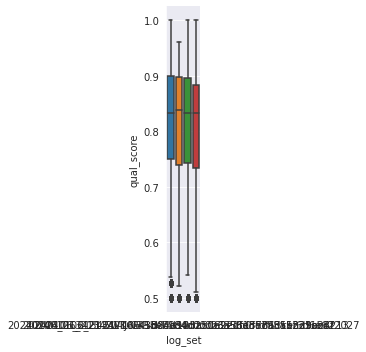

In [7]:
g = sns.catplot(
    image_info_df, 
    x="log_set", 
    y="qual_score", 
    kind="box"
)
# g.set(xlim=(0, 1), ylim=(0, 1))
g.tight_layout()
plt.show()

In [14]:
def gather_log_set_stats(
        stats_df, 
        target_metric
        ):
    unique_log_sets = stats_df['log_set'].unique()
    for log_set in unique_log_sets:
        log_set_df = stats_df[stats_df['log_set'] == log_set]
        qual_metric_df = log_set_df[log_set_df['qual_metric'] == target_metric]
        # Calculate basic statistics of performance.
        log_set_mean = qual_metric_df['qual_score'].mean()
        log_set_std = qual_metric_df['qual_score'].std()
        log_set_min = qual_metric_df['qual_score'].min()
        log_set_max = qual_metric_df['qual_score'].max()
        print(f"{log_set} | {target_metric} : {log_set_mean:.3f} +- {log_set_std:.3f} [{log_set_min:.3f}, {log_set_max:.3f}]")

In [15]:
gather_log_set_stats(image_info_df, 'Dice')

20240106_213421-5WKO-41304d9dd251e9edb0f5c95a5223a24f | Dice : 0.806 +- 0.117 [0.500, 1.000]
20240106_213421-TJ65-5beb9d4cd0c2633813fdf13cec31cbc7 | Dice : 0.803 +- 0.121 [0.500, 0.962]
20240106_213421-1NSP-d83a125ac06221fd5786c513d9bc8213 | Dice : 0.801 +- 0.123 [0.500, 1.000]
20240106_213421-GK3B-7184d0c0b3a56ede7a81bf6d6e622027 | Dice : 0.786 +- 0.132 [0.500, 1.000]
